In [1]:
#!pip install tqdm

import urllib.request
import zipfile
import os
from tqdm import tqdm

# Function to download a file with a progress bar
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

#url = "https://nlp.stanford.edu/data/glove.6B.zip"
#output = "glove.6B.zip"

# Download the GloVe embeddings with a progress bar
#with DownloadProgressBar(unit='B', unit_scale=True, miniters=1, desc=url.split('/')[-1]) as t:
    #urllib.request.urlretrieve(url, filename=output, reporthook=t.update_to)


# Unzip the downloaded file
#with zipfile.ZipFile(output, 'r') as zip_ref:
    #zip_ref.extractall()

# Ensure gensim is installed
#!pip install gensim

# Import KeyedVectors from gensim and load the word vectors
from gensim.models import KeyedVectors
word_vectors = KeyedVectors.load_word2vec_format('glove.6B.50d.txt', binary=False, no_header=True)

In [2]:
#!pip install torch torch-geometric

import pandas as pd
import os
from collections import defaultdict, Counter
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.nn import Linear
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.optim import Adam
from torch.nn.functional import cross_entropy
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight
torch.manual_seed(42)

In [3]:
!unzip drive/MyDrive/slt_challenge/transcripts_outputFiles.zip


Archive:  drive/MyDrive/slt_challenge/transcripts_outputFiles.zip
   creating: transcripts_outputFiles/
   creating: transcripts_outputFiles/SFT_outputFiles/
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-103.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-034.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-131.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-039.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-059.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-073.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-030.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-080.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-069.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-test-002.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-083.txt  
  inflating: tra

In [3]:
def load_graph_info(nodes_degree_txt, nodes_edges_txt):
  nodes_features = defaultdict(dict)
  edges = []
  with open(nodes_degree_txt, 'r') as nodes_degree_file, open(nodes_edges_txt, 'r') as nodes_edges_file:
      reading_nodes, reading_edges = False, False

      for line in nodes_edges_file:
          line = line.strip()
          if (not line) or line.startswith("id*int") or line.startswith("source*int"):
              continue

          if line.startswith("*Nodes"):
              # start reading node info
              reading_nodes = True
              reading_edges = False
          elif line.startswith("*DirectedEdges"):
              # start reading edge info
              reading_nodes = False
              reading_edges = True

          elif reading_nodes:
            # parse node info
              parts = line.split(" ", 2)
              node_id = int(parts[0])
              label = parts[1].strip('"')
              nodes_features[node_id]['label'] = label


          elif reading_edges:
            # parse edge info
              parts = line.split()
              source = int(parts[0])
              target = int(parts[1])
              edges.append((source, target))

      for line in nodes_degree_file:
        line = line.strip()
        if (not line) or (not line.startswith("Node Degree")):
          parts = line.split()
          node_id = int(parts[0])
          degree = parts[1].strip('"')
          nodes_features[node_id]['degree'] = degree

      # print(len(nodes_features), len(edges))
      return nodes_features, edges


def get_word_embedding(word, embedding_dim=50):
    try:
        return torch.tensor(word_vectors[word], dtype=torch.float)
    except KeyError:
        # for words not in the vocabulary, use a zero vector
        # print('WARNING: word not in the vocabulary: ', word)
        return torch.zeros(embedding_dim)


def prep_data_for_gnn(nodes_features, edges):
    # mapping from node ID to index
    node_id_to_index = {node_id: i for i, node_id in enumerate(nodes_features.keys())}

    # create node features: node degrees and word embeddings)
    features = []
    for node_id in nodes_features.keys():
        node_label = nodes_features[node_id]['label']
        node_embeddings = get_word_embedding(node_label)
        # print(node_id,nodes_features[node_id]['degree'])
        # new_value = torch.tensor([15], dtype=torch.int64)
        # tensor = torch.cat((node_embeddings, new_value))

        features.append(node_embeddings)
    x = torch.stack(features)  # Node feature matrix

    # create edge index tensor
    edge_index = torch.tensor(
        [[node_id_to_index[src], node_id_to_index[dst]] for src, dst in edges],
        dtype=torch.long,
    ).t().contiguous()
    return x, edge_index


def get_datalist(id_list, label_list, transcript_folder):
  """
  returns a list of Data objects
  """
  data_list = []
  id_label_list = [(id, label) for id, label in zip(id_list, label_list)]
  for id, label in id_label_list:
    filepath = os.path.join(transcript_folder, id)
    nodes_features, edges = load_graph_info(f'{filepath}_dir_nodes_degree.txt', f'{filepath}_dir_nodes_edges.txt')
    x, edge_index = prep_data_for_gnn(nodes_features, edges)
    graph_data = Data(x=x, edge_index=edge_index, y=label)
    data_list.append(graph_data)
  return data_list


def get_dataloader(data_list, batch_size=None):
  if not batch_size:
    batch_size = len(data_list)
    print('Setting batch size to ', batch_size)
  return DataLoader(data_list, batch_size=batch_size, shuffle=False)


def calculate_class_weights(labels):
    class_weights = compute_class_weight(
        class_weight = 'balanced',
        classes = np.unique(labels),
        y = labels)
   
    return torch.tensor(class_weights, dtype=torch.float)

class GNNClassifier(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNClassifier, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return x


def train_gnn(train_datalist, train_batch_size=None, hidden_dim=64, lr=0.01, epoches=250, class_weights=None, num_classes = 3):
  torch.manual_seed(42)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  train_dataloader = get_dataloader(train_datalist, batch_size=train_batch_size)

  num_node_features = next(iter(train_dataloader)).x.size(1)

  model = GNNClassifier(input_dim=num_node_features, hidden_dim=hidden_dim, output_dim=num_classes).to(device)
  optimizer = Adam(model.parameters(), lr=lr)

  # Train
  if class_weights is not None:
      class_weights = class_weights.to(device) 
  loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
  for epoch in range(epoches):  # train for 50 epochs
      model.train()
      total_loss = 0

      for batch in train_dataloader:
          batch = batch.to(device)
          optimizer.zero_grad()
          out = model(batch)
          loss = cross_entropy(out, batch.y)
          loss.backward()
          optimizer.step()
          total_loss += loss.item()

      if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.5f}')

  return model


def eval_gnn(model, eval_datalist, print_results=True, batch_size=None):
    model.eval()
    logits_list, pred_list, y_list = [], [], []
    eval_dataloader = get_dataloader(eval_datalist, batch_size=batch_size)
    for batch in eval_dataloader:
        logits = model(batch)
        pred = logits.argmax(dim=1)
        logits_list.append(logits)
        pred_list.append(pred)
        y_list.append(batch.y)
    # concatenate data from all batches
    logits_all = torch.cat(logits_list, dim=0)
    pred_all = torch.cat(pred_list, dim=0)
    y_all = torch.cat(y_list, dim=0)
    # get metrics
    results, disp = calc_metrics(y_all, pred_all)
    return logits_all, pred_all, results, disp


def calc_metrics(actual_labels, pred_vals, print_results=True):
  results = {}
  results['accuracy'] = accuracy_score(actual_labels, pred_vals)
  results['f1'] = f1_score(actual_labels, pred_vals, average='macro')
  results['precision'] = precision_score(actual_labels, pred_vals, average='macro')
  results['recall'] = recall_score(actual_labels, pred_vals, average='macro')

  cm = confusion_matrix(actual_labels, pred_vals)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['HC', 'MCI', 'DEM'])
  # print and plot results
  if print_results:
    for metric, value in results.items():
      print(f'{metric}: {value:.3f}')
    disp.plot()
    plt.show()
  return results, disp


class NNMetaModel(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
      super().__init__()
      self.fc1 = Linear(input_dim, hidden_dim)
      self.fc2 = Linear(hidden_dim, output_dim)

  def forward(self, x):
      x = self.fc1(x)
      x = x.relu()
      x = self.fc2(x)
      return x

def train_nn_metamodel(features, labels, class_weights=None, epochs=50, hidden_dim=32, lr=0.01, n_tasks=3):
    num_classes = len(torch.unique(labels))
    input_dim = n_tasks * num_classes  # input dimensions equals to number of tasks (CTD, SFT, PFT) * number of classes
    model = NNMetaModel(input_dim, hidden_dim=hidden_dim, output_dim=num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    if class_weights is not None:
        class_weights = class_weights.to(features.device)  # Move class weights to the same device as the model
    loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(features)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')
    return model


Fold 0:

    train set for base model: 100 samples; label count: Counter({0: 52, 1: 38, 2: 10}),
    train set for meta model: 25 samples; label count: Counter({0: 13, 1: 10, 2: 2}),
    dev set for meta model: 32 samples; label count: Counter({0: 17, 1: 11, 2: 4})
Class weights for base model:  tensor([0.6410, 0.8772, 3.3333])
Class weights for combined model:  tensor([0.6410, 0.8681, 3.4722])
----------- Task: CTD -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.11547
Epoch 50, Loss: 0.37590
Epoch 100, Loss: 0.01822
Epoch 150, Loss: 0.00238
Epoch 200, Loss: 0.00116
Validating on meta model train set...
Setting batch size to  25
accuracy: 0.400
f1: 0.267
precision: 0.256
recall: 0.279


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


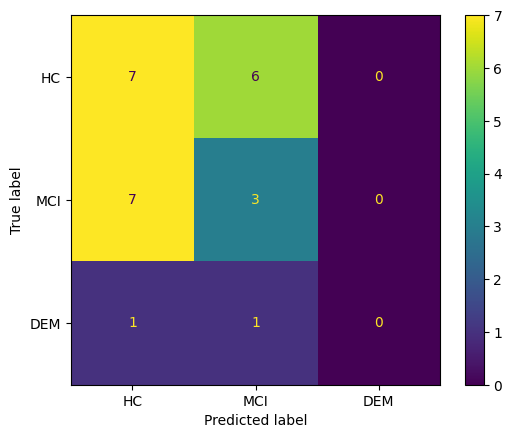

Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.375
f1: 0.265
precision: 0.248
recall: 0.289


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


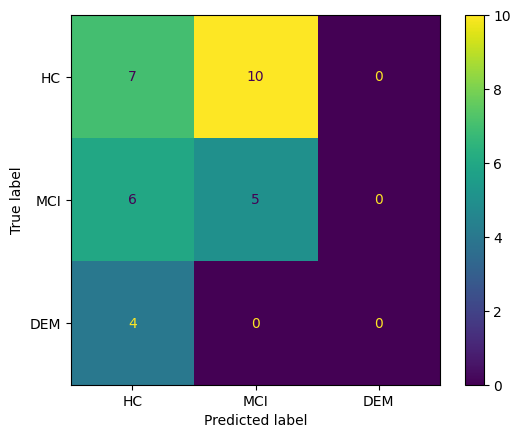

Training on base model train set + meta model train set...
Setting batch size to  125
Epoch 0, Loss: 1.11585
Epoch 50, Loss: 0.55008
Epoch 100, Loss: 0.05214
Epoch 150, Loss: 0.00511
Epoch 200, Loss: 0.00224
Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.406
f1: 0.293
precision: 0.284
recall: 0.319


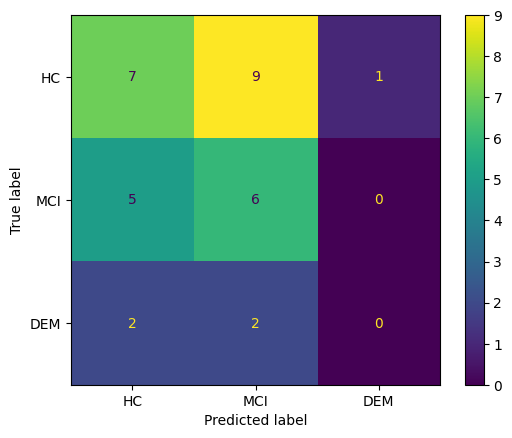

----------- Task: SFT -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.11269
Epoch 50, Loss: 0.26999
Epoch 100, Loss: 0.00345
Epoch 150, Loss: 0.00121
Epoch 200, Loss: 0.00071
Validating on meta model train set...
Setting batch size to  25
accuracy: 0.520
f1: 0.340
precision: 0.352
recall: 0.356


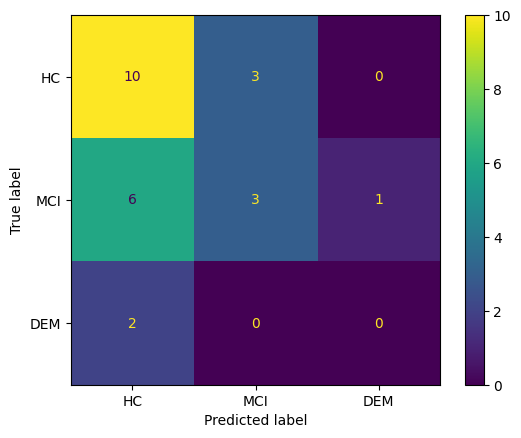

Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.406
f1: 0.267
precision: 0.259
recall: 0.276


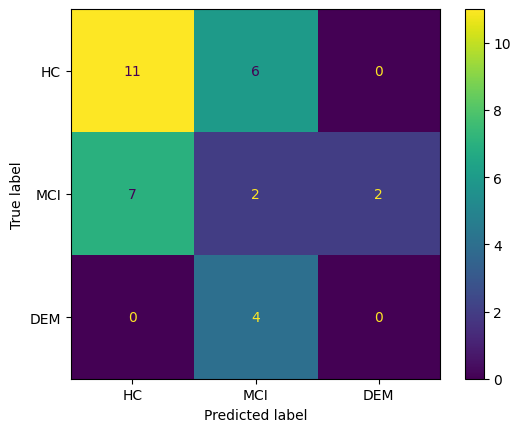

Training on base model train set + meta model train set...
Setting batch size to  125
Epoch 0, Loss: 1.11367
Epoch 50, Loss: 0.32773
Epoch 100, Loss: 0.00661
Epoch 150, Loss: 0.00189
Epoch 200, Loss: 0.00104
Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.469
f1: 0.339
precision: 0.342
recall: 0.348


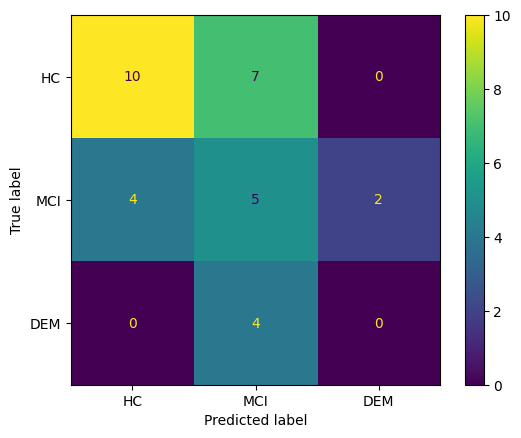

----------- Task: PFT -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.08750
Epoch 50, Loss: 0.00399
Epoch 100, Loss: 0.00036
Epoch 150, Loss: 0.00022
Epoch 200, Loss: 0.00016
Validating on meta model train set...
Setting batch size to  25
accuracy: 0.480
f1: 0.338
precision: 0.339
recall: 0.338


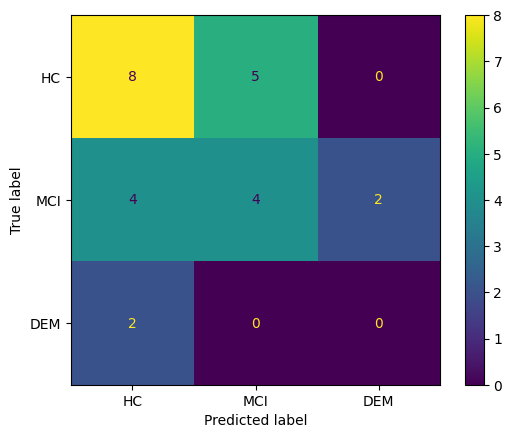

Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.594
f1: 0.504
precision: 0.550
recall: 0.490


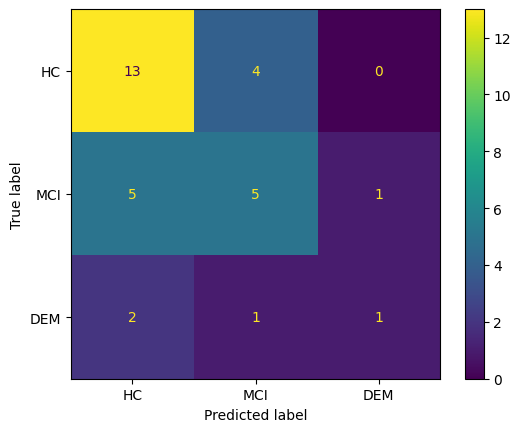

Training on base model train set + meta model train set...
Setting batch size to  125
Epoch 0, Loss: 1.08508
Epoch 50, Loss: 0.01183
Epoch 100, Loss: 0.00063
Epoch 150, Loss: 0.00036
Epoch 200, Loss: 0.00024
Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.562
f1: 0.463
precision: 0.476
recall: 0.459


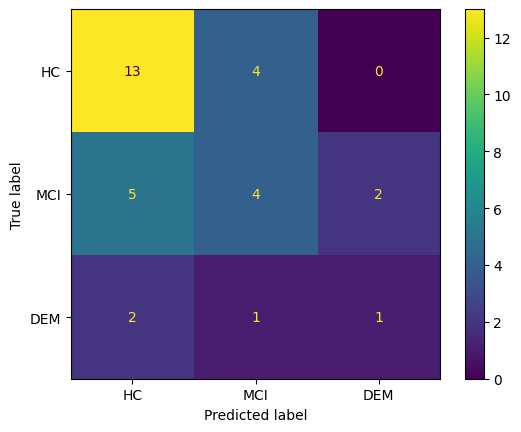

Fold 1:

    train set for base model: 100 samples; label count: Counter({0: 51, 1: 39, 2: 10}),
    train set for meta model: 25 samples; label count: Counter({0: 13, 1: 10, 2: 2}),
    dev set for meta model: 32 samples; label count: Counter({0: 18, 1: 10, 2: 4})
Class weights for base model:  tensor([0.6536, 0.8547, 3.3333])
Class weights for combined model:  tensor([0.6510, 0.8503, 3.4722])
----------- Task: CTD -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.11436
Epoch 50, Loss: 0.45450
Epoch 100, Loss: 0.02127
Epoch 150, Loss: 0.00341
Epoch 200, Loss: 0.00169
Validating on meta model train set...
Setting batch size to  25
accuracy: 0.480
f1: 0.346
precision: 0.357
recall: 0.338


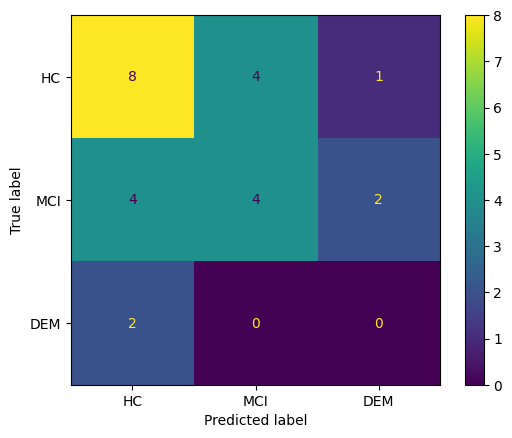

Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.375
f1: 0.258
precision: 0.250
recall: 0.267


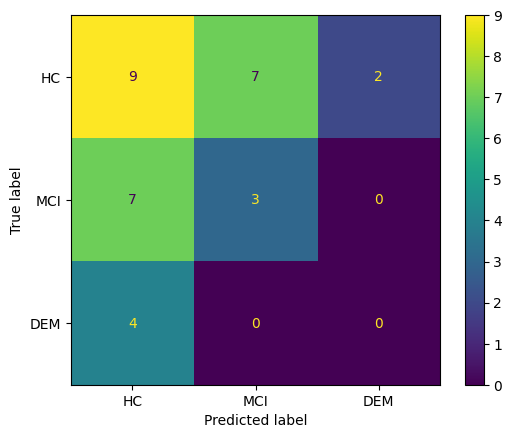

Training on base model train set + meta model train set...
Setting batch size to  125
Epoch 0, Loss: 1.11448
Epoch 50, Loss: 0.53622
Epoch 100, Loss: 0.06750
Epoch 150, Loss: 0.00566
Epoch 200, Loss: 0.00245
Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.500
f1: 0.420
precision: 0.426
recall: 0.420


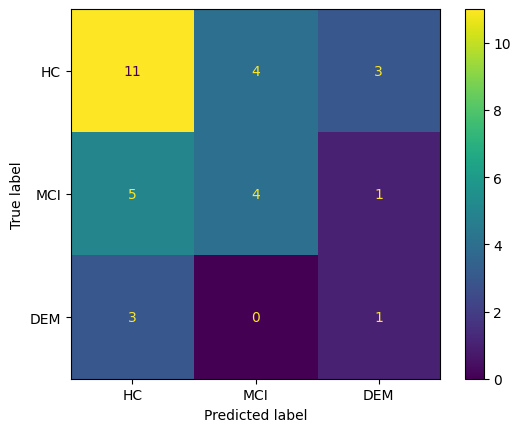

----------- Task: SFT -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.11441
Epoch 50, Loss: 0.19329
Epoch 100, Loss: 0.00330
Epoch 150, Loss: 0.00122
Epoch 200, Loss: 0.00072
Validating on meta model train set...
Setting batch size to  25
accuracy: 0.480
f1: 0.319
precision: 0.333
recall: 0.331


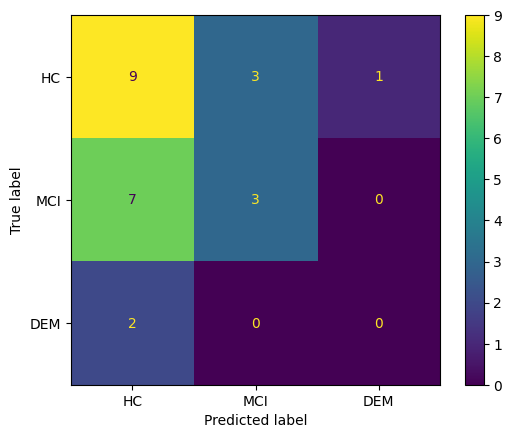

Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.625
f1: 0.430
precision: 0.404
recall: 0.459


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


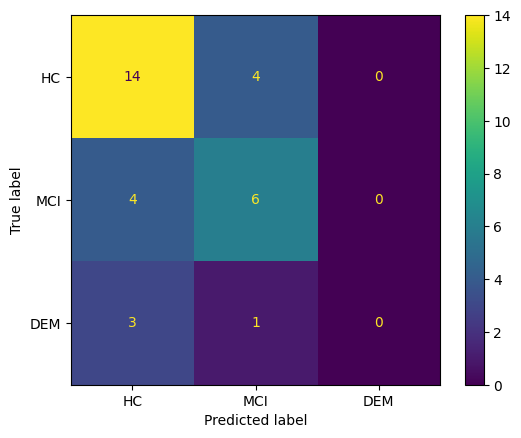

Training on base model train set + meta model train set...
Setting batch size to  125
Epoch 0, Loss: 1.11202
Epoch 50, Loss: 0.37307
Epoch 100, Loss: 0.00761
Epoch 150, Loss: 0.00198
Epoch 200, Loss: 0.00110
Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.625
f1: 0.400
precision: 0.376
recall: 0.430


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


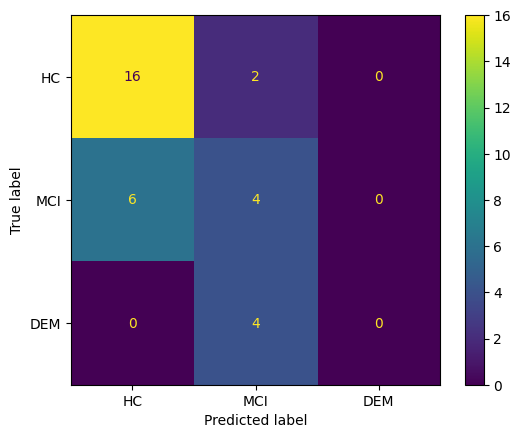

----------- Task: PFT -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.08339
Epoch 50, Loss: 0.00160
Epoch 100, Loss: 0.00021
Epoch 150, Loss: 0.00014
Epoch 200, Loss: 0.00010
Validating on meta model train set...
Setting batch size to  25
accuracy: 0.440
f1: 0.272
precision: 0.262
recall: 0.297


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


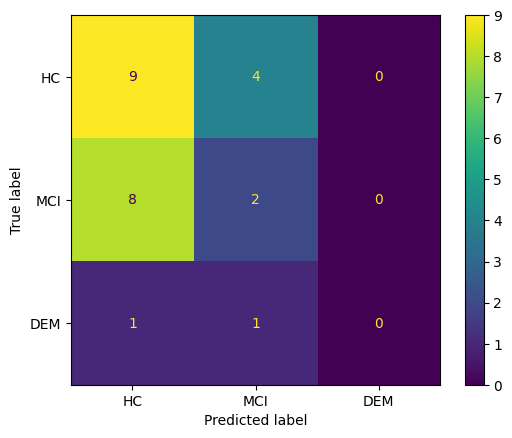

Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.594
f1: 0.421
precision: 0.419
recall: 0.426


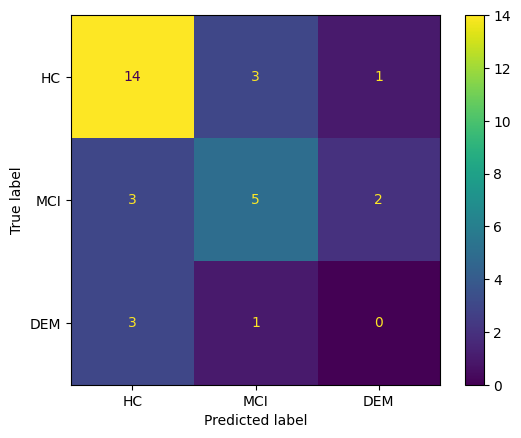

Training on base model train set + meta model train set...
Setting batch size to  125
Epoch 0, Loss: 1.08311
Epoch 50, Loss: 0.00556
Epoch 100, Loss: 0.00048
Epoch 150, Loss: 0.00030
Epoch 200, Loss: 0.00021
Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.500
f1: 0.369
precision: 0.383
recall: 0.356


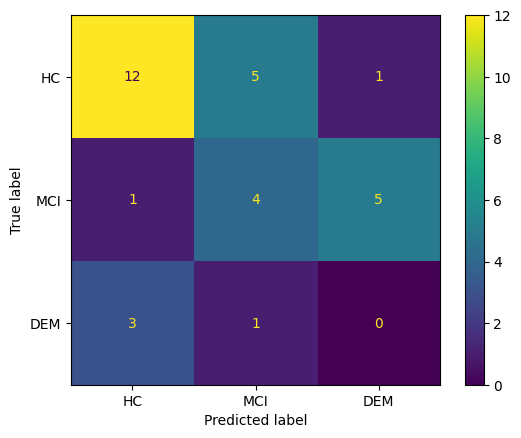

Fold 2:

    train set for base model: 100 samples; label count: Counter({0: 52, 1: 37, 2: 11}),
    train set for meta model: 26 samples; label count: Counter({0: 14, 1: 9, 2: 3}),
    dev set for meta model: 31 samples; label count: Counter({0: 16, 1: 13, 2: 2})
Class weights for base model:  tensor([0.6410, 0.9009, 3.0303])
Class weights for combined model:  tensor([0.6364, 0.9130, 3.0000])
----------- Task: CTD -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.11465
Epoch 50, Loss: 0.45102
Epoch 100, Loss: 0.02071
Epoch 150, Loss: 0.00350
Epoch 200, Loss: 0.00173
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.423
f1: 0.308
precision: 0.315
recall: 0.302


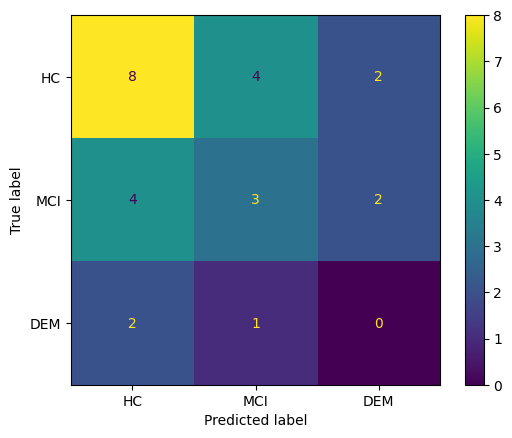

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.419
f1: 0.290
precision: 0.286
recall: 0.295


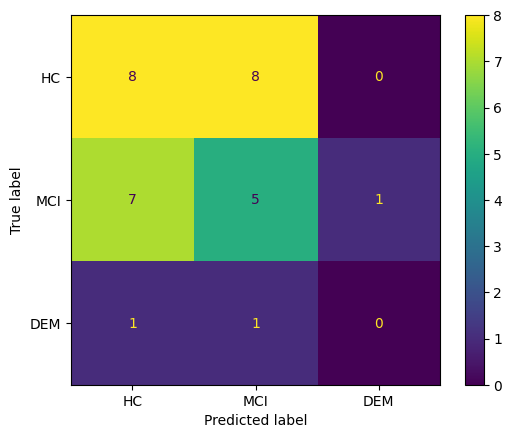

Training on base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 1.11444
Epoch 50, Loss: 0.54945
Epoch 100, Loss: 0.07410
Epoch 150, Loss: 0.00667
Epoch 200, Loss: 0.00275
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.516
f1: 0.362
precision: 0.363
recall: 0.362


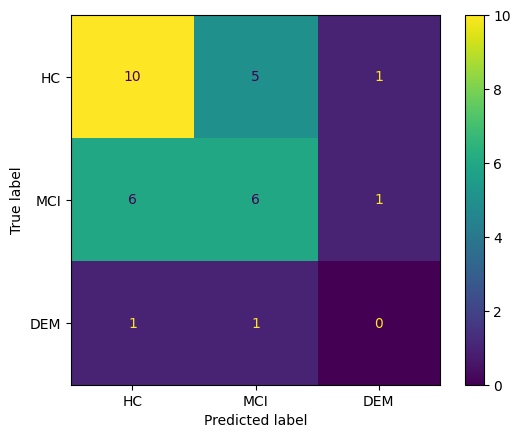

----------- Task: SFT -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.11138
Epoch 50, Loss: 0.21260
Epoch 100, Loss: 0.00278
Epoch 150, Loss: 0.00105
Epoch 200, Loss: 0.00063
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.577
f1: 0.406
precision: 0.395
recall: 0.423


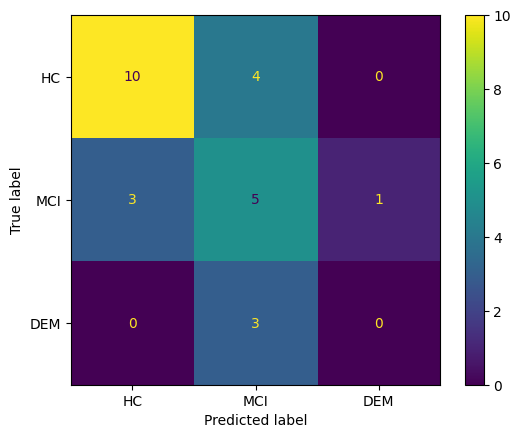

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.452
f1: 0.417
precision: 0.402
recall: 0.462


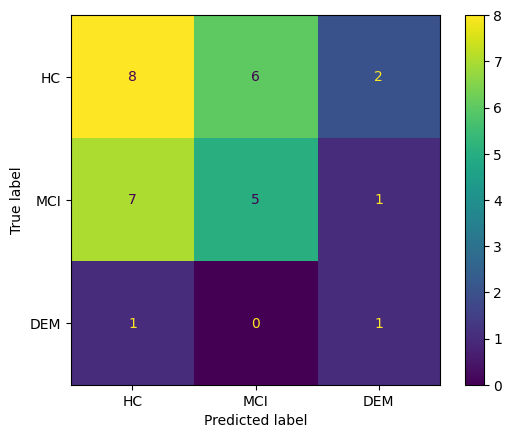

Training on base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 1.11161
Epoch 50, Loss: 0.31460
Epoch 100, Loss: 0.00561
Epoch 150, Loss: 0.00157
Epoch 200, Loss: 0.00088
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.484
f1: 0.459
precision: 0.443
recall: 0.487


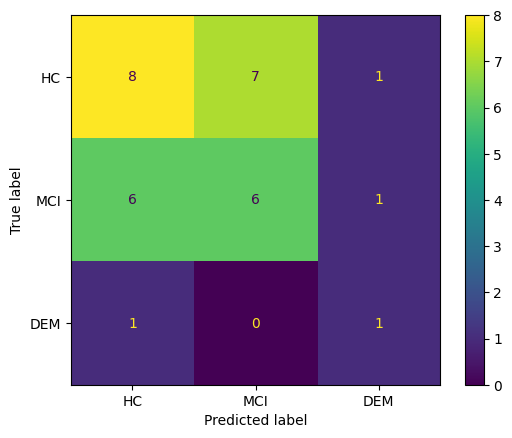

----------- Task: PFT -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.08464
Epoch 50, Loss: 0.00603
Epoch 100, Loss: 0.00036
Epoch 150, Loss: 0.00023
Epoch 200, Loss: 0.00016
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.346
f1: 0.308
precision: 0.305
recall: 0.315


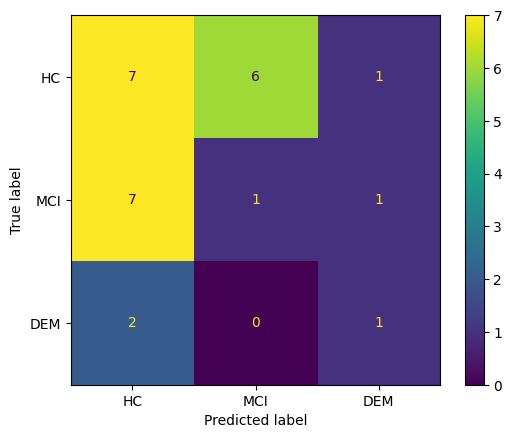

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.548
f1: 0.376
precision: 0.375
recall: 0.383


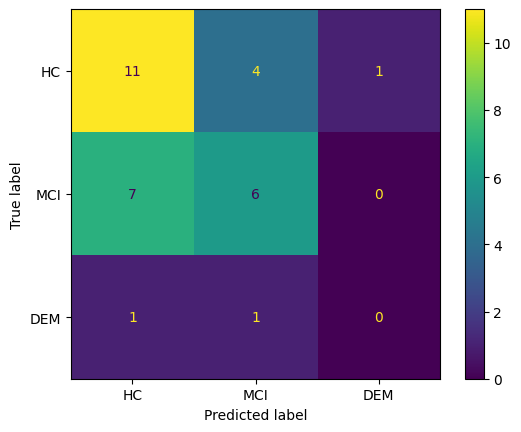

Training on base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 1.08671
Epoch 50, Loss: 0.02133
Epoch 100, Loss: 0.00080
Epoch 150, Loss: 0.00044
Epoch 200, Loss: 0.00029
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.419
f1: 0.287
precision: 0.291
recall: 0.290


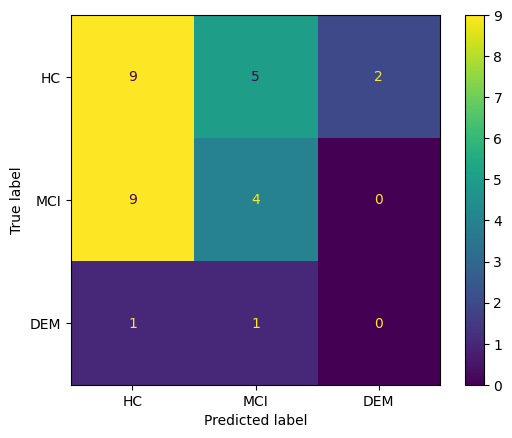

Fold 3:

    train set for base model: 100 samples; label count: Counter({0: 52, 1: 37, 2: 11}),
    train set for meta model: 26 samples; label count: Counter({0: 14, 1: 9, 2: 3}),
    dev set for meta model: 31 samples; label count: Counter({0: 16, 1: 13, 2: 2})
Class weights for base model:  tensor([0.6410, 0.9009, 3.0303])
Class weights for combined model:  tensor([0.6364, 0.9130, 3.0000])
----------- Task: CTD -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.11440
Epoch 50, Loss: 0.49690
Epoch 100, Loss: 0.02871
Epoch 150, Loss: 0.00368
Epoch 200, Loss: 0.00174
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.423
f1: 0.283
precision: 0.283
recall: 0.288


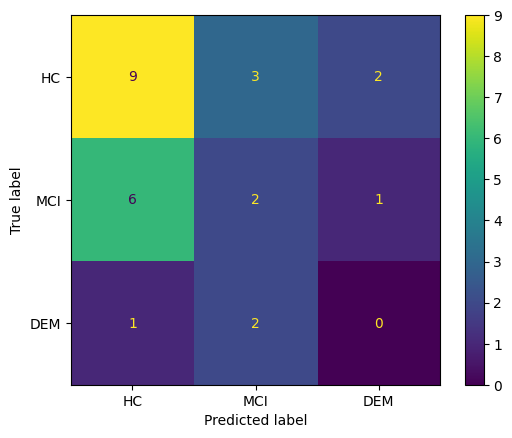

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.452
f1: 0.310
precision: 0.305
recall: 0.316


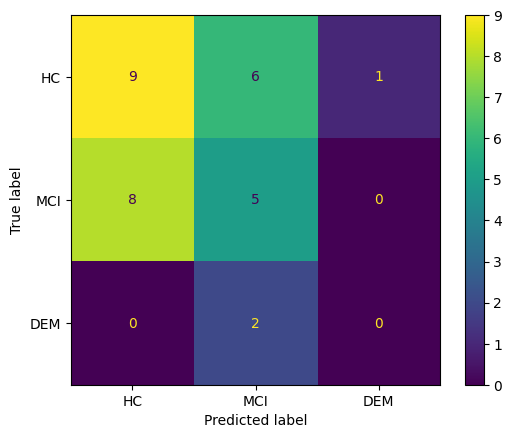

Training on base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 1.11445
Epoch 50, Loss: 0.60931
Epoch 100, Loss: 0.11307
Epoch 150, Loss: 0.00966
Epoch 200, Loss: 0.00352
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.548
f1: 0.361
precision: 0.357
recall: 0.378


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


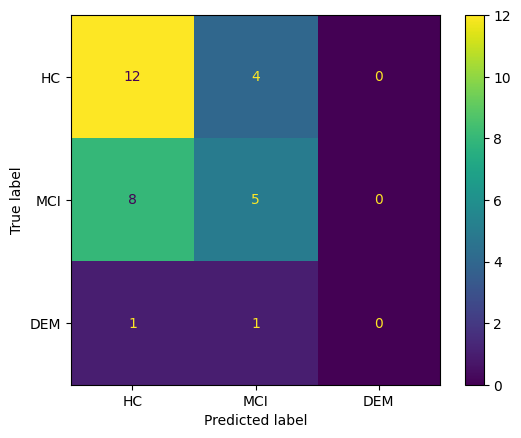

----------- Task: SFT -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.11441
Epoch 50, Loss: 0.23761
Epoch 100, Loss: 0.00318
Epoch 150, Loss: 0.00127
Epoch 200, Loss: 0.00076
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.423
f1: 0.353
precision: 0.346
recall: 0.362


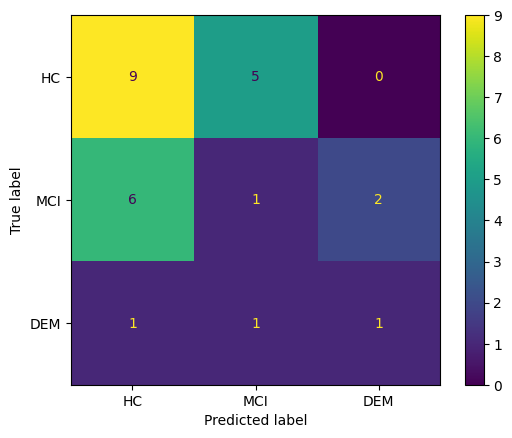

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.581
f1: 0.389
precision: 0.382
recall: 0.404


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


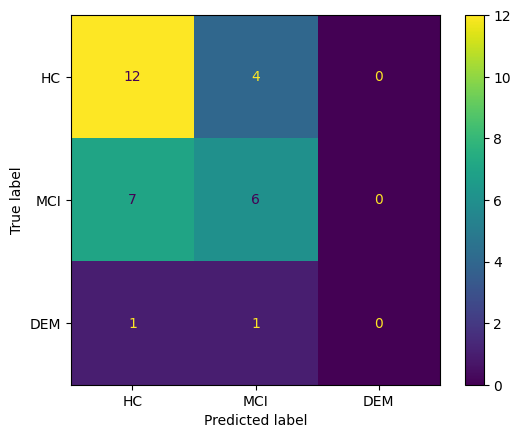

Training on base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 1.11406
Epoch 50, Loss: 0.33240
Epoch 100, Loss: 0.00564
Epoch 150, Loss: 0.00182
Epoch 200, Loss: 0.00104
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.581
f1: 0.399
precision: 0.386
recall: 0.413


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


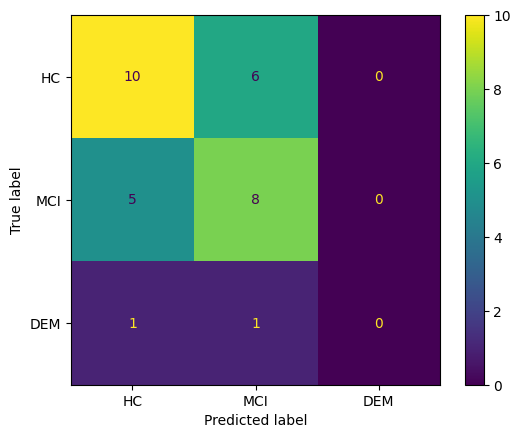

----------- Task: PFT -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.08766
Epoch 50, Loss: 0.00272
Epoch 100, Loss: 0.00024
Epoch 150, Loss: 0.00016
Epoch 200, Loss: 0.00012
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.231
f1: 0.165
precision: 0.179
recall: 0.156


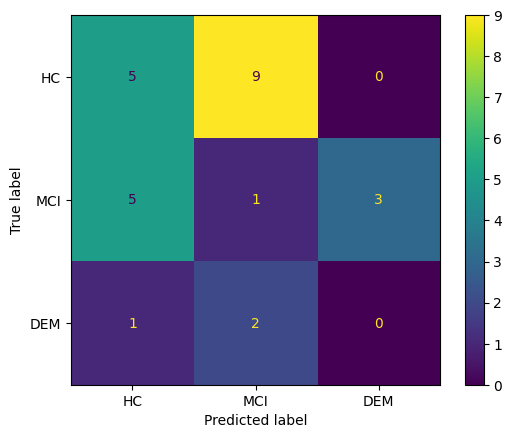

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.452
f1: 0.300
precision: 0.304
recall: 0.306


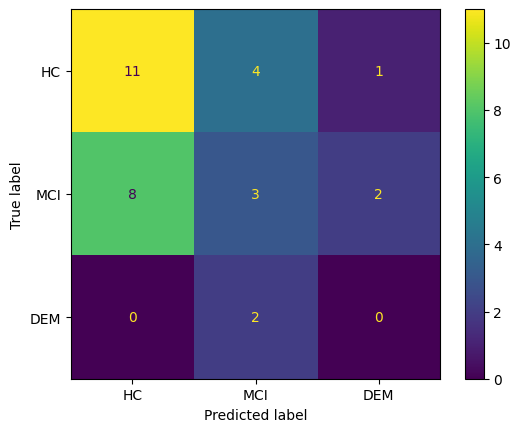

Training on base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 1.08675
Epoch 50, Loss: 0.01383
Epoch 100, Loss: 0.00072
Epoch 150, Loss: 0.00041
Epoch 200, Loss: 0.00027
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.484
f1: 0.337
precision: 0.352
recall: 0.332


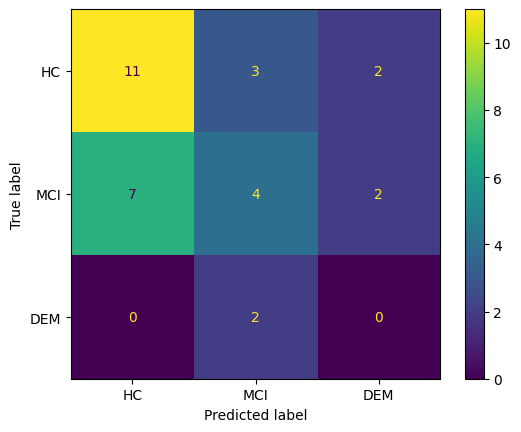

Fold 4:

    train set for base model: 100 samples; label count: Counter({0: 53, 1: 37, 2: 10}),
    train set for meta model: 26 samples; label count: Counter({0: 14, 1: 10, 2: 2}),
    dev set for meta model: 31 samples; label count: Counter({0: 15, 1: 12, 2: 4})
Class weights for base model:  tensor([0.6289, 0.9009, 3.3333])
Class weights for combined model:  tensor([0.6269, 0.8936, 3.5000])
----------- Task: CTD -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.11473
Epoch 50, Loss: 0.48393
Epoch 100, Loss: 0.04846
Epoch 150, Loss: 0.00533
Epoch 200, Loss: 0.00215
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.538
f1: 0.381
precision: 0.382
recall: 0.381


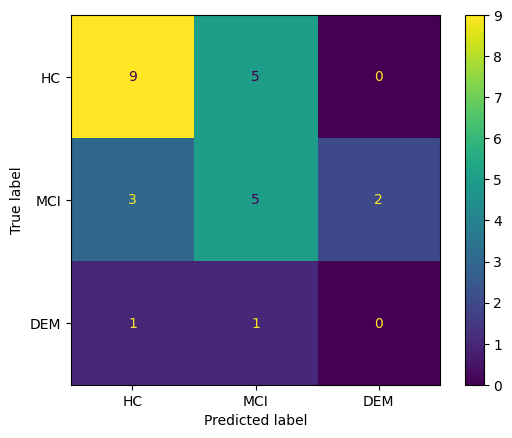

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.452
f1: 0.315
precision: 0.295
recall: 0.339


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


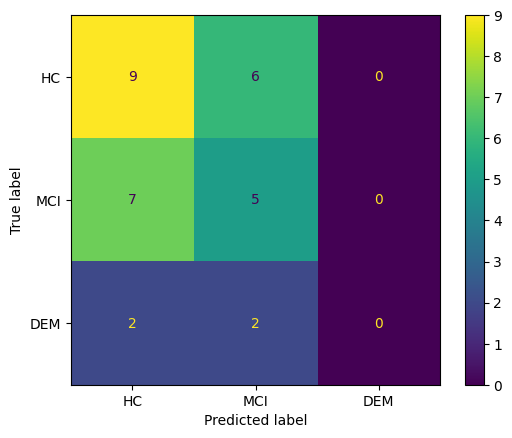

Training on base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 1.11510
Epoch 50, Loss: 0.54032
Epoch 100, Loss: 0.08739
Epoch 150, Loss: 0.00821
Epoch 200, Loss: 0.00300
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.452
f1: 0.326
precision: 0.315
recall: 0.339


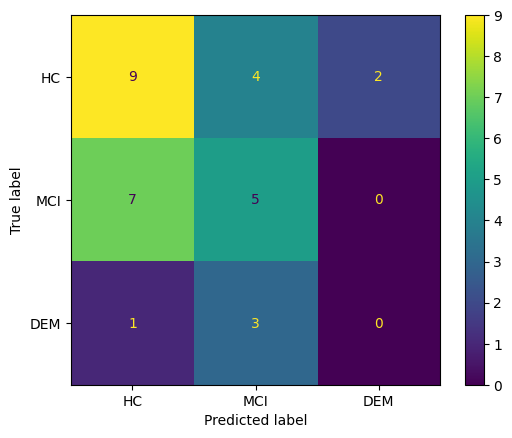

----------- Task: SFT -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.10918
Epoch 50, Loss: 0.17180
Epoch 100, Loss: 0.00259
Epoch 150, Loss: 0.00110
Epoch 200, Loss: 0.00067
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.385
f1: 0.261
precision: 0.278
recall: 0.257


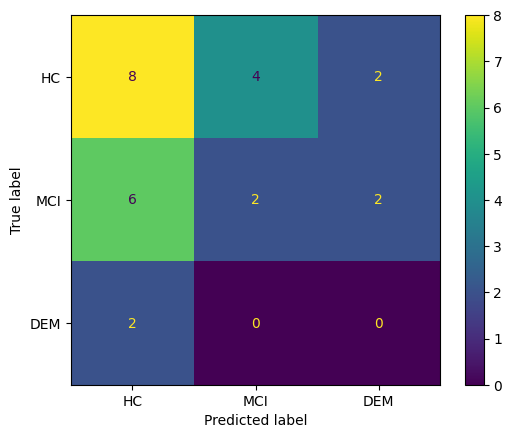

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.419
f1: 0.280
precision: 0.270
recall: 0.306


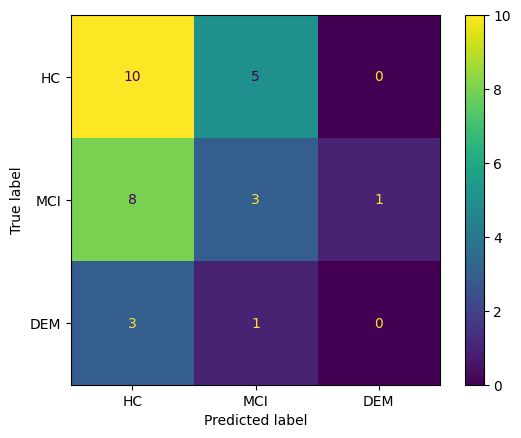

Training on base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 1.11199
Epoch 50, Loss: 0.30834
Epoch 100, Loss: 0.00598
Epoch 150, Loss: 0.00171
Epoch 200, Loss: 0.00094
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.484
f1: 0.335
precision: 0.318
recall: 0.361


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


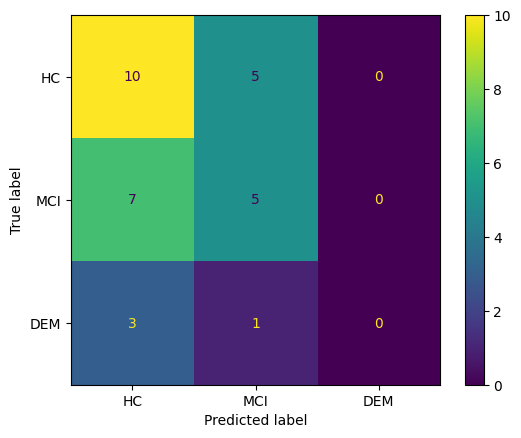

----------- Task: PFT -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.08900
Epoch 50, Loss: 0.00363
Epoch 100, Loss: 0.00026
Epoch 150, Loss: 0.00017
Epoch 200, Loss: 0.00012
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.423
f1: 0.277
precision: 0.274
recall: 0.281


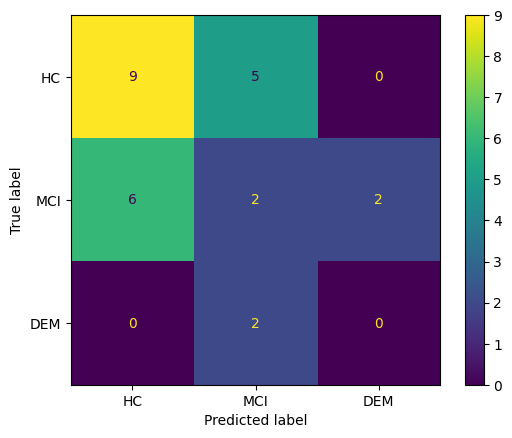

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.452
f1: 0.409
precision: 0.458
recall: 0.394


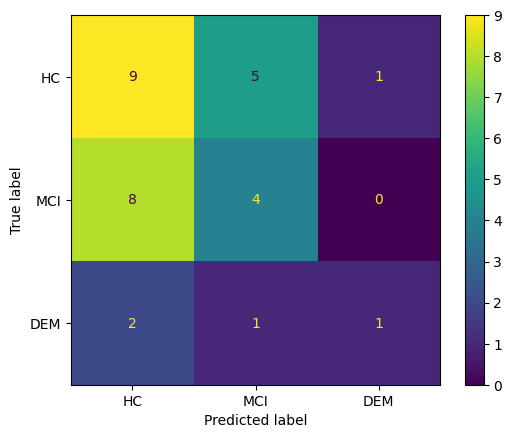

Training on base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 1.08506
Epoch 50, Loss: 0.01188
Epoch 100, Loss: 0.00055
Epoch 150, Loss: 0.00032
Epoch 200, Loss: 0.00022
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.387
f1: 0.340
precision: 0.343
recall: 0.344


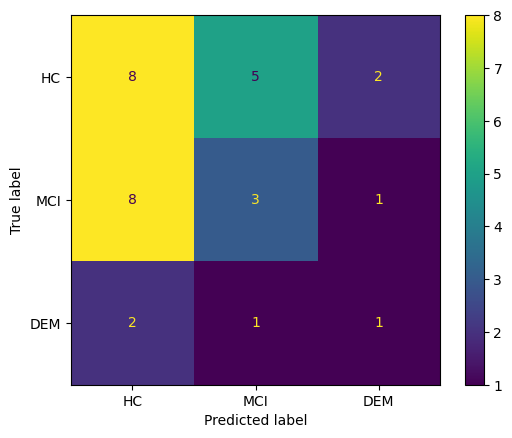


----------- Task: CTD -----------

              precision    recall  f1-score   support

           0     0.5568    0.5976    0.5765        82
           1     0.4407    0.4407    0.4407        59
           2     0.1000    0.0625    0.0769        16

    accuracy                         0.4841       157
   macro avg     0.3658    0.3669    0.3647       157
weighted avg     0.4666    0.4841    0.4745       157


----------- Task: SFT -----------

              precision    recall  f1-score   support

           0     0.6207    0.6585    0.6391        82
           1     0.4308    0.4746    0.4516        59
           2     0.2000    0.0625    0.0952        16

    accuracy                         0.5287       157
   macro avg     0.4172    0.3985    0.3953       157
weighted avg     0.5064    0.5287    0.5132       157


----------- Task: PFT -----------

              precision    recall  f1-score   support

           0     0.5824    0.6463    0.6127        82
           1     0.40

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

TASKS = ['CTD', 'SFT', 'PFT']
LABEL_MAPPING = {'HC': 0,
                 'MCI': 1,
                 'Dementia': 2}

metadata = pd.read_csv("PROCESS_METADATA_ALL.csv")
# shuffle df
metadata = metadata.sample(frac=1, random_state=42, ignore_index=False)
metadata['diagnosis_coded'] = metadata['diagnosis'].map(LABEL_MAPPING)

df_traindev = metadata[metadata['Tr/Tt/Dv'].isin(['train', 'dev'])]
id_traindev, label_traindev = df_traindev['anyon_IDs'], df_traindev['diagnosis_coded']
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf_dict = defaultdict(dict)

all_preds_across_folds = defaultdict(list)
all_trues_across_folds = defaultdict(list)

for fold_index, (train_index, dev_index) in enumerate(skf.split(id_traindev, label_traindev)):
    print(f"Fold {fold_index}:")
    base_train_id, ensemble_train_id, base_train_label, ensemble_train_label = train_test_split(id_traindev[train_index], label_traindev[train_index],
                                                    stratify=label_traindev[train_index],
                                                    test_size=0.2)
    print(f'''
    train set for base model: {len(base_train_label)} samples; label count: {Counter(base_train_label)},
    train set for meta model: {len(ensemble_train_label)} samples; label count: {Counter(ensemble_train_label)},
    dev set for meta model: {len(label_traindev[dev_index])} samples; label count: {Counter(label_traindev[dev_index])}''')

    class_weights_base = calculate_class_weights(base_train_label)
    combined_labels = np.concatenate([base_train_label, ensemble_train_label])
    class_weights_combined = calculate_class_weights(combined_labels)
    print('Class weights for base model: ', class_weights_base)
    print('Class weights for combined model: ', class_weights_combined)

    logits_for_ensemble_training = []
    pred_for_ensemble_training = []

    logits_for_ensemble_validation = []
    pred_for_ensemble_validation = []

    for task in TASKS:
        print(f'----------- Task: {task} -----------')
        transcript_folder = f"transcripts_outputFiles/{task}_outputFiles"
        base_train_datalist = get_datalist(base_train_id, base_train_label, transcript_folder)
        ensemble_train_datalist = get_datalist(ensemble_train_id, ensemble_train_label, transcript_folder)
        ensemble_dev_datalist = get_datalist(id_traindev[dev_index], label_traindev[dev_index], transcript_folder)
        # training gnn in order to get the logits
        print('Training base model...')
        trained_gnn = train_gnn(base_train_datalist)
        # get logits and pred for metamodel training
        print('Validating on meta model train set...')
        task_logits_ensemble_training, task_pred_ensemble_training, _, _ = eval_gnn(trained_gnn, ensemble_train_datalist, print_results=False)
        logits_for_ensemble_training.append(task_logits_ensemble_training)
        pred_for_ensemble_training.append(task_pred_ensemble_training)
        # get logits and pred for metamodel validation
        print('Validating on meta model dev set...')
        task_logits_ensemble_validation, task_pred_ensemble_validation, _, _ = eval_gnn(trained_gnn, ensemble_dev_datalist, print_results=False)
        logits_for_ensemble_validation.append(task_logits_ensemble_validation)
        pred_for_ensemble_validation.append(task_pred_ensemble_validation)

        # for comparison: gnn only, no metamodel
        print('Training on base model train set + meta model train set...')
        trained_gnn_individual_task = train_gnn(base_train_datalist + ensemble_train_datalist)
        print('Validating on meta model dev set...')
        _, all_preds, kf_dict[fold_index][f'{task}_gnn_results'], kf_dict[fold_index][f'{task}_gnn_cm_disp'] = eval_gnn(trained_gnn_individual_task, ensemble_dev_datalist)

        all_preds_across_folds[task].extend(all_preds.tolist())
        all_trues_across_folds[task].extend(label_traindev[dev_index].tolist())
        
    kf_dict[fold_index]['logits_for_ensemble_training'] = logits_for_ensemble_training
    kf_dict[fold_index]['logits_for_ensemble_validation'] = logits_for_ensemble_validation
    kf_dict[fold_index]['pred_for_ensemble_training'] = pred_for_ensemble_training
    kf_dict[fold_index]['pred_for_ensemble_validation'] = pred_for_ensemble_validation
    kf_dict[fold_index]['ensemble_train_label'] = ensemble_train_label
    kf_dict[fold_index]['ensemble_dev_label'] = label_traindev[dev_index]

for task in all_preds_across_folds.keys():
    print(f'\n----------- Task: {task} -----------\n')
    print(classification_report(all_trues_across_folds[task], all_preds_across_folds[task], digits=4))


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# train and validate meta models
all_preds_meta_model = defaultdict(list)
all_trues_meta_model = defaultdict(list)


for fold in kf_dict.keys():
    print(f"Fold {fold}:")
    fold_dict = kf_dict[fold]
    logits_for_ensemble_training, ensemble_train_label, logits_for_ensemble_validation = fold_dict['logits_for_ensemble_training'], fold_dict['ensemble_train_label'], fold_dict['logits_for_ensemble_validation']
    ensemble_train_features = torch.cat(logits_for_ensemble_training, dim=1).detach()
    ensemble_train_labels = torch.tensor(ensemble_train_label.values, dtype=torch.int64).to(device)
    ensemble_validation_features = torch.cat(logits_for_ensemble_validation, dim=1).detach().to(device)

    class_weights_ensemble = calculate_class_weights(ensemble_train_label)
    class_weights_dict = {i: weight for i, weight in enumerate(class_weights_ensemble.tolist())}
    print(f'Class weights for fold {fold}: ', class_weights_dict)

    knn_model = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='minkowski')
    lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
    svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')
    rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

    # apply machine learning models as metamodel:
    for model_name, ensemble_model in {'lr': lr_model, 'svm': svm_model, 'rf': rf_model, 'knn': knn_model}.items():
        print(f'Training {model_name}...')
        ensemble_model.fit(ensemble_train_features, ensemble_train_labels)
        y_pred = ensemble_model.predict(ensemble_validation_features)
        ensemble_validation_labels = fold_dict['ensemble_dev_label'].to_numpy()
        all_preds_meta_model[model_name].extend(y_pred.tolist())
        all_trues_meta_model[model_name].extend(ensemble_validation_labels.tolist())

    # apply nn model as metamodel:
    nn_meta_model = train_nn_metamodel(features=ensemble_train_features, labels=ensemble_train_labels)
    nn_meta_model.eval()
    with torch.no_grad():
        ensemble_validation_labels = torch.tensor(fold_dict['ensemble_dev_label'].values, dtype=torch.int64).to(device)
        validation_pred = nn_meta_model(ensemble_validation_features).argmax(dim=1)
        all_preds_meta_model['nn'].extend(validation_pred.tolist())
        all_trues_meta_model['nn'].extend(ensemble_validation_labels.tolist())

for model_name in all_preds_meta_model.keys():
    print(f'\n----------- Model: {model_name} -----------\n')
    print(classification_report(all_trues_meta_model[model_name], all_preds_meta_model[model_name], digits=4))

Fold 0:
Class weights for fold 0:  {0: 0.6410256624221802, 1: 0.8333333134651184, 2: 4.166666507720947}
Training lr...
Training svm...
Training rf...


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training knn...
Epoch 10, Loss: 0.6751
Epoch 20, Loss: 0.4504
Epoch 30, Loss: 0.2852
Epoch 40, Loss: 0.1761
Epoch 50, Loss: 0.1227
Fold 1:
Class weights for fold 1:  {0: 0.6410256624221802, 1: 0.8333333134651184, 2: 4.166666507720947}
Training lr...
Training svm...
Training rf...


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training knn...
Epoch 10, Loss: 0.5401
Epoch 20, Loss: 0.2211
Epoch 30, Loss: 0.0809
Epoch 40, Loss: 0.0286
Epoch 50, Loss: 0.0127
Fold 2:
Class weights for fold 2:  {0: 0.6190476417541504, 1: 0.9629629850387573, 2: 2.8888888359069824}
Training lr...
Training svm...
Training rf...


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training knn...
Epoch 10, Loss: 0.4814
Epoch 20, Loss: 0.2541
Epoch 30, Loss: 0.1350
Epoch 40, Loss: 0.0723
Epoch 50, Loss: 0.0416
Fold 3:
Class weights for fold 3:  {0: 0.6190476417541504, 1: 0.9629629850387573, 2: 2.8888888359069824}
Training lr...
Training svm...
Training rf...


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training knn...
Epoch 10, Loss: 0.4473
Epoch 20, Loss: 0.2053
Epoch 30, Loss: 0.0917
Epoch 40, Loss: 0.0389
Epoch 50, Loss: 0.0193
Fold 4:
Class weights for fold 4:  {0: 0.6190476417541504, 1: 0.8666666746139526, 2: 4.333333492279053}
Training lr...
Training svm...
Training rf...


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training knn...
Epoch 10, Loss: 0.4975
Epoch 20, Loss: 0.2759
Epoch 30, Loss: 0.1552
Epoch 40, Loss: 0.0852
Epoch 50, Loss: 0.0468

----------- Model: lr -----------

              precision    recall  f1-score   support

           0     0.4940    0.5000    0.4970        82
           1     0.3889    0.3559    0.3717        59
           2     0.1000    0.1250    0.1111        16

    accuracy                         0.4076       157
   macro avg     0.3276    0.3270    0.3266       157
weighted avg     0.4143    0.4076    0.4106       157


----------- Model: svm -----------

              precision    recall  f1-score   support

           0     0.4762    0.7317    0.5769        82
           1     0.1935    0.1017    0.1333        59
           2     0.0000    0.0000    0.0000        16

    accuracy                         0.4204       157
   macro avg     0.2232    0.2778    0.2368       157
weighted avg     0.3214    0.4204    0.3514       157


----------- Model: rf -----------

c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera